<h2>Topic: Time Series Analysis and Forcasting Champagne Sales</h2>
<div style="float:right;">
<ul>Owner:-
    <li>Name: Yash Ketan Kanakia</li>
    <li>Roll No: E21027</li>
</ul>
</div>

1. Problem Statement


2. Heuristic Approach
  - Naive Forecast
  - Simple Average Forecast
  - Moving Average Forecast
  - Weighted Moving Average Forecast
  
  
3. Exponential Smoothing
  - Simple Exponential Smoothing
  - Double Exponential Smoothing
  - Triple Exponential Smoothing
  
  
4. Stationarity
  - Checking Stationarity using Graphs
  - ADF Test
  - Making Time Series Stationary

### Problem Statement
- We are provided with 8 years of data(Jan 1964-Sept 1972) and using this data we have to forecast the sales of Champagne.

### Dataset and Libraries

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima 
import warnings
warnings.filterwarnings("ignore")


# Read the Champagne dataset
df = pd.read_csv(r'C:\Users\Owner\Downloads\TF\Champagne_Sales_Forecasting\Champagne.csv',index_col ='Month',parse_dates = True)

In [2]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [3]:
df.tail()

,Sales
Month,
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298
1972-08-01,1413
1972-09-01,5877


### Train and Test Split

- Creating train and test file for modeling. (January 1964 – Sep 1971) are used as training data and (Oct 1971 - Sep 1972) as testing data.

In [89]:
#Creating train and test set 
train = df.loc['1964-01-01':'1971-10-01']  #Creating a training dataset for learning
test = df.loc['1971-10-01':] #One year data for forecasting

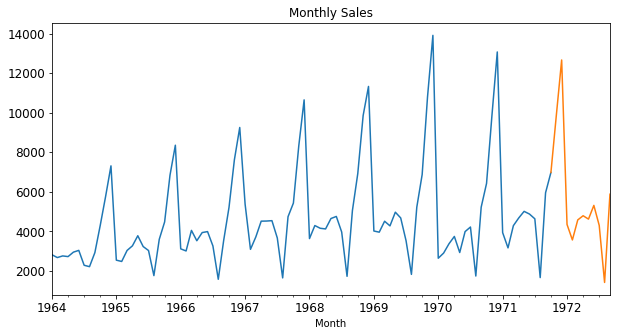

In [5]:
#Plotting data
train.Sales.plot(figsize=(10,5), title= 'Monthly Sales', fontsize=12)
test.Sales.plot(figsize=(10,5), title= 'Monthly Sales', fontsize=12)
plt.show()

## Heuristic Approach

### 1. Naive Forecast

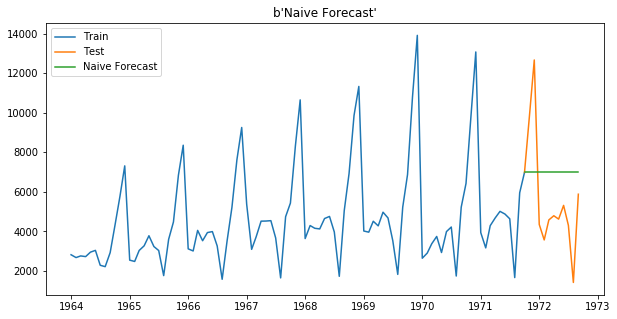

In [6]:
dd= np.asarray(train.Sales)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(10,5))
plt.plot(train.index, train['Sales'], label='Train')
plt.plot(test.index,test['Sales'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title(b"Naive Forecast")
plt.show()

- Naive Method is forecasting technique which assumes that the next value's best estimate is previous value

In [7]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Sales, y_hat.naive))
print("Root Mean Square Error: ",rms)

Root Mean Square Error:  3130.3344203668294


- The value looks quite high as there is certainly some varaition in the data and Naive Forecast is best appraoch for stable data.

### 2. Simple Average Forecast

- The idea here is to understand that sometimes data varies a lot but average is usually constant over the time. Here, avarage is used to forecast the values.

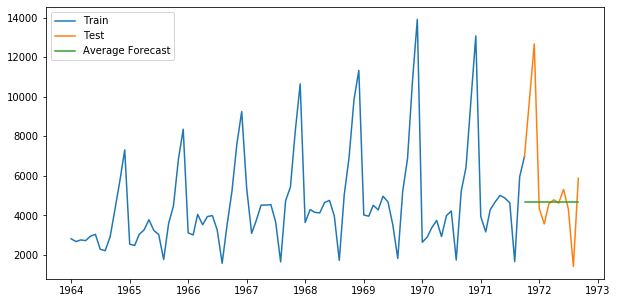

In [8]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Sales'].mean()
plt.figure(figsize=(10,5))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [9]:
rms = sqrt(mean_squared_error(test.Sales, y_hat_avg.avg_forecast))
print("Root Mean Square Error: ",rms)

Root Mean Square Error:  3031.076695291178


- The error reduced as compared to Naive but not to a great extent.

### 3. Moving Average Forecast

- The Average probably did not improve the rmse as there an increase in sales over each year which means average must be increasing too. Here, we need to take average of per year to forecast.

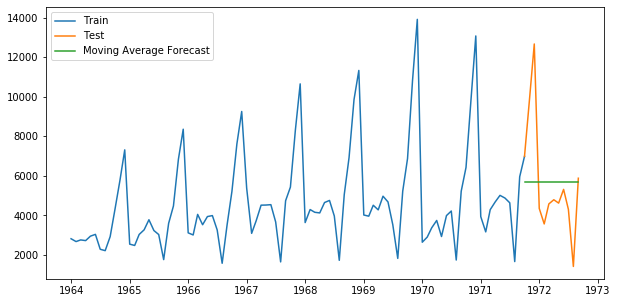

In [10]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Sales'].rolling(12).mean().iloc[-1]
plt.figure(figsize=(10,5))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [11]:
rms = sqrt(mean_squared_error(test.Sales, y_hat_avg.moving_avg_forecast))
print("Root Mean Square Error: ",rms)

Root Mean Square Error:  2852.4171280200626


- The value reduced certainly compared to naive and simple avg but we are still not sure if this is the final model.

### Weighted Moving Average Forecast

- As we could infer from the moving average that average sales of each year is different rather it is increasing. So, we could try giving more importance to recent years and try to forecast the sales.

In [12]:
#Creating train and test set 
train = df.loc['1964-01-01':'1970-10-01']
test = df.loc['1970-10-01':]

In [13]:
#Weights to be given to years. Eg:- 12 to most recent, 11 to next most recent and so on...
weights = np.arange(1,13)
weights

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [14]:
#Calculating Weighted Moving Average
y_hat = test.copy()
y_hat['wma_sales'] = test['Sales'].rolling(12).apply(lambda sales: np.dot(sales, weights)/weights.sum(), raw=True)

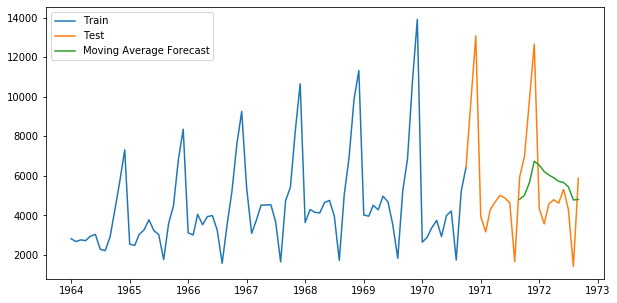

In [15]:
plt.figure(figsize=(10,5))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat['wma_sales'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [16]:
y_actual= test[test.index > '1971-09-01']
y_hat= y_hat[y_hat.index > '1971-09-01']

In [17]:
rms = sqrt(mean_squared_error(y_actual.Sales, y_hat.wma_sales))
print(rms)

2690.728787338142


- Giving more importance to the last 12 years in forecasting reduced the RMSE considerably but not quite accurate in capturing the fluctuation in the sales.

## Exponential Smoothing

- Exponential smoothing, is used to weight data from previous time periods with exponentially decreasing importance in the forecast.

- If a is chosen to be less than .5, less weight is placed on the actual value than on the forecast of that value. If a is chosen to be greater than .5, more weight is being put on the actual value than on the forecast value.

- An exponential smoothing of time series data allocates the exponentially decaying weights

In [18]:
train = df.loc['1964-01-01':'1971-10-01']
test = df.loc['1971-10-01':] 

### 1. Simple Exponential Smoothing

- Single exponential smoothing only estimates the level component. Level is also called base.

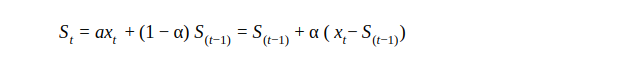

In [19]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()

alpha_list = [0.2,0.5,0.8]
alpha_mse_values = {}
for i in alpha_list:

    fit2 = SimpleExpSmoothing(np.asarray(train['Sales'])).fit(smoothing_level=i,optimized=False)
    y_hat_avg['SES'] = fit2.forecast(len(test))

    rms = sqrt(mean_squared_error(test.Sales, y_hat_avg.SES))
    alpha_mse_values[i] = rms

In [20]:
RMSE = min(alpha_mse_values.values())
best_alpha = [key for key in alpha_mse_values if alpha_mse_values[key] == RMSE]

print("The lowest RMSE :",RMSE," at alpha: ",best_alpha)

The lowest RMSE : 2853.7104279652585  at alpha:  [0.5]


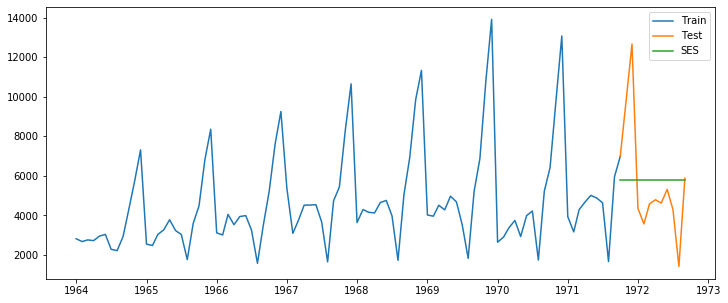

In [21]:
fit2 = SimpleExpSmoothing(np.asarray(train['Sales'])).fit(smoothing_level=0.5,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))

plt.figure(figsize=(12,5))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

- Giving equal importance to the actual values and forecasted values has reduced the RMSE to great extent but it is still not accurate in capturing the fluctuation in the sales.

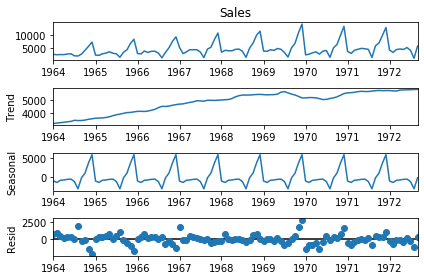

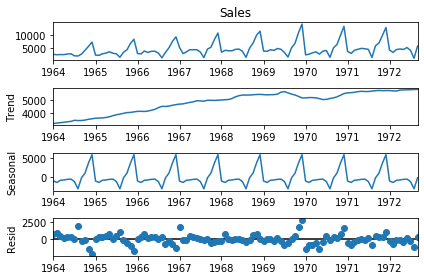

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
# Additive Decomposition
result_add = seasonal_decompose(df.Sales, model='additive', extrapolate_trend='freq')
result_add.plot()

In [23]:
# Extract the Components ----
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['Seasonality', 'Trend', 'Residual', 'Actual_values']
df_reconstructed.head()

,Seasonality,Trend,Residual,Actual_values
Month,,,,
1964-01-01,-1146.366240,3223.150010,738.216230,2815.0
1964-02-01,-1522.127539,3255.293366,938.834173,2672.0
1964-03-01,-943.124949,3287.436723,410.688226,2755.0
1964-04-01,-850.419373,3319.580080,251.839293,2721.0
1964-05-01,-694.906488,3351.723436,289.183051,2946.0


#### Need to address the trend and seasonality too

### Double Exponential as it has Trend

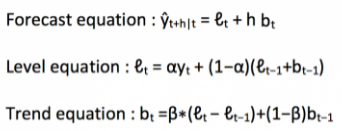

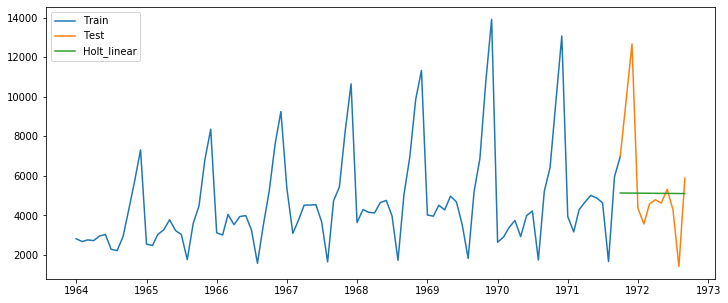

In [24]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Sales'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(12,5))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [25]:
rms = sqrt(mean_squared_error(test.Sales, y_hat_avg.Holt_linear))
print(rms)

2905.0332337664513


### Triple Exponential as it has Trend and Seasonality

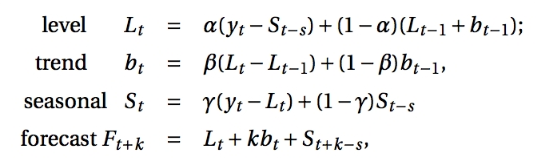

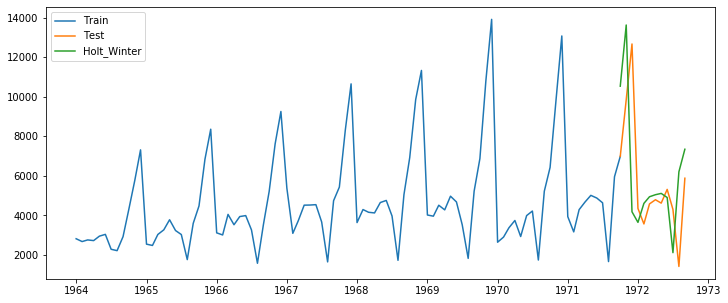

In [26]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(12,5))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [27]:
rms = sqrt(mean_squared_error(test.Sales, y_hat_avg.Holt_Winter))
print(rms)

3304.760140625756


## Stationarity

- For modeling, we should check the property of time series: stationarity.

- If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance.

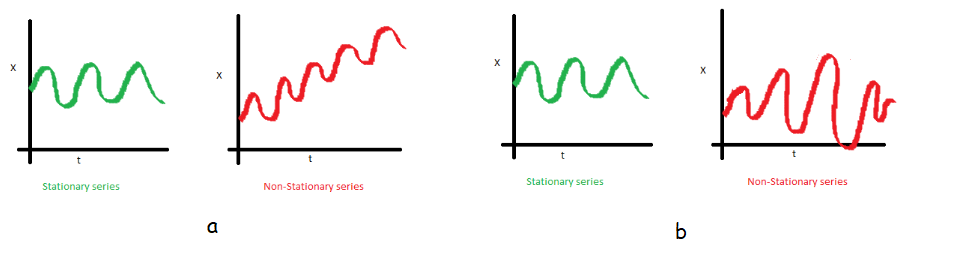

- In (a) the red image ; mean changes over time

- In (b) the red image ; variance changes over time

#### checking the mean and variance 

In [28]:
year_wise_data = df_reconstructed.groupby(df_reconstructed.index.year)
year_wise_data.apply(lambda x: x) 

print("Mean of Year wise Data: \n",year_wise_data['Actual_values'].mean())
print("\n")
print("Variance of Year wise Data: \n",year_wise_data['Actual_values'].var())

Mean of Year wise Data: 
 Month
1964    3478.166667
1965    3864.166667
1966    4337.666667
1967    5016.000000
1968    5370.583333
1969    5713.416667
1970    5006.583333
1971    5640.583333
1972    4310.555556
Name: Actual_values, dtype: float64


Variance of Year wise Data: 
 Month
1964    2.418942e+06
1965    3.613359e+06
1966    4.493930e+06
1967    5.667333e+06
1968    7.416728e+06
1969    1.143903e+07
1970    1.105047e+07
1971    8.973456e+06
1972    1.600605e+06
Name: Actual_values, dtype: float64


#### Plotting Mean and Variance

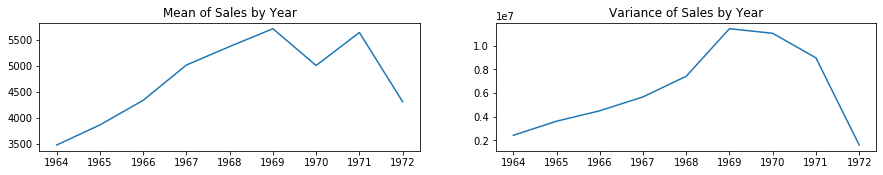

In [29]:
#plot 1:
plt.figure(figsize=(15,8))
ax1 =  plt.subplot(3, 2, 1)
plt.plot(year_wise_data['Actual_values'].mean())

#plot 2:

ax2 = plt.subplot(3, 2, 2)
plt.plot(year_wise_data['Actual_values'].var())

ax1.set_title('Mean of Sales by Year')
ax2.set_title('Variance of Sales by Year')
plt.show()

- This gives us a brief idea over mean and variance of the timeseries and presumming that there is no stationarity.

### Statistical Test for Stationarty

- When a time series is stationary, it can be easier to model. 
- Statistical modeling methods assume or require the time series to be stationary.

#### Dickey-Fuller Test

In [30]:
# check_mean_std
def check_mean_std(ts):
    #Rolling statistics
    
    rolmean = ts['Sales'].rolling(12).mean()
    rolstd = ts['Sales'].rolling(12).std()
    plt.figure(figsize=(8,4))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

In [31]:
# adfuller library 
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

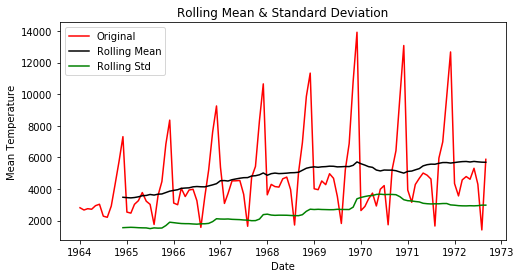

Test statistic:  -1.8335930563276184
p-value:  0.36391577166024713
Critical Values: {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}


In [32]:
check_mean_std(df)
check_adfuller(df.Sales)

- If the test statistic is less than the critical value, we can say that time series is stationary.
- Test statistic = -1.833 ; is bigger than the critical values. <b>(no stationary)</b>
- As a result, we sure that our time series is not stationary.

#### Making the time series stationary

<ul>As we mentioned before, there are 2 reasons behind non-stationarity of time series
    <li>Trend: varying mean over time. We need constant mean for stationary of time series.</li>
    <li>Seasonality: variations at specific time. We need constant variations for stationary of time series.</li></ul>

#### Differencing Method to address the change in mean and variance.

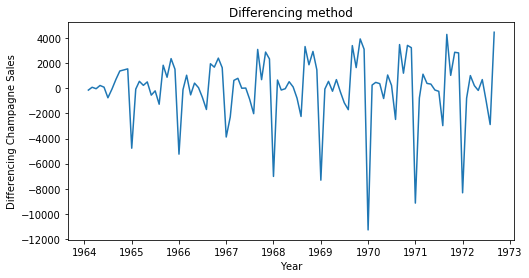

In [33]:
# Differencing method
ts_diff = df - df.shift()
plt.figure(figsize=(8,4))
plt.plot(ts_diff)
plt.title("Differencing method") 
plt.xlabel("Year")
plt.ylabel("Differencing Champagne Sales")
plt.show()

- Checking Time series after differencing with mean and standard deviation

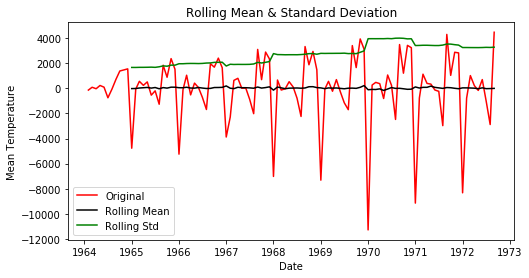

Test statistic:  -7.18989644805098
p-value:  2.519620447387365e-10
Critical Values: {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}


In [34]:
ts_diff.dropna(inplace=True) # due to shifting there is nan values
check_mean_std(ts_diff)
check_adfuller(ts_diff.Sales)

- Constant mean criteria: mean looks is almost constant (yes stationary)
- Second one is constant variance. It looks like constant. (yes stationary)
- The test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series. (yes stationary)

#### Autocorrelation and Partial Autocorrelation

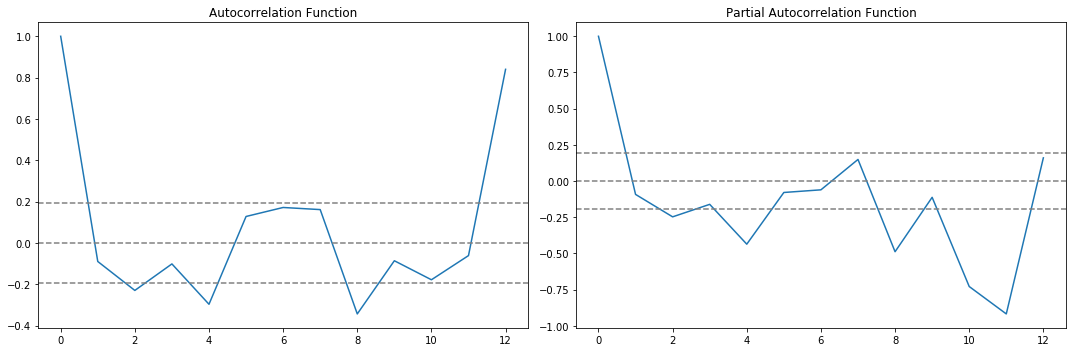

In [76]:
# ACF and PACF 
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=12)
lag_pacf = pacf(ts_diff, nlags=12, method='ols')
# ACF
plt.figure(figsize=(15,5))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### ARIMA Model

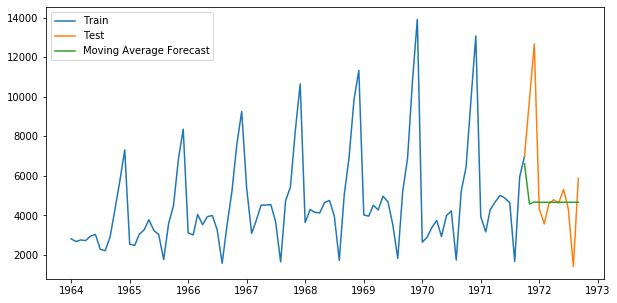

In [129]:
# ARIMA LİBRARY
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime

# fit model
model = ARIMA(train['Sales'], order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit = model.fit()

# predict
start_index = datetime(1971,10,1)
end_index = datetime(1972, 9, 1)
forecast = model_fit.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(10,5))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(forecast, label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

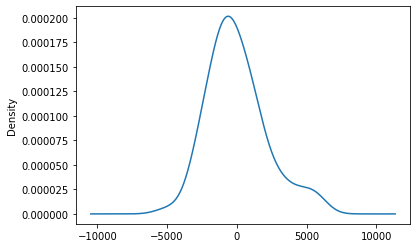

count      94.000000
mean       -0.543297
std      2120.828933
min     -5016.201094
25%     -1259.587562
50%      -350.231751
75%      1078.326258
max      5885.781411
dtype: float64


In [246]:
residuals = model_fit.resid
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [247]:
rms = sqrt(mean_squared_error(test.Sales,forecast))
print("Root Mean Squared Error: ", rms)

Root Mean Squared Error:  2970.0212942998287


### SARIMA

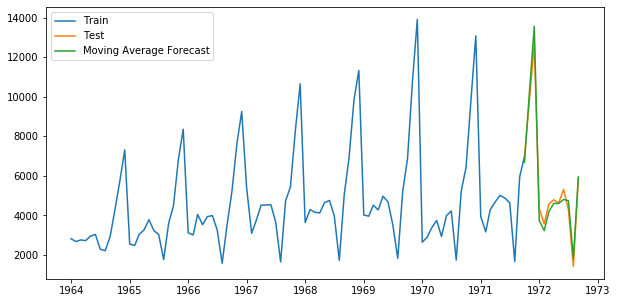

In [249]:
#SARIMAX Library

mod = sm.tsa.statespace.SARIMAX(train['Sales'], trend='n', order=(1,0,1), seasonal_order=(1,1,1,12))
results = mod.fit()

# visualization
df['forecast'] = results.predict(start = 93, end= 104, dynamic= True) 
plt.figure(figsize=(10,5))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df['forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

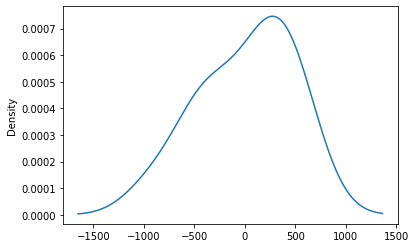

count     12.000000
mean      10.126182
std      463.588444
min     -897.617395
25%     -411.026482
50%      100.610104
75%      350.697505
max      610.253446
dtype: float64

In [250]:
#Residual Analysis
residuals = test.Sales-df['forecast'].tail(12)
residuals.plot(kind='kde')
plt.show()
residuals.describe()

In [251]:
rms = sqrt(mean_squared_error(test.Sales,df['forecast'].tail(12)))
print("Root Mean Squared Error: ", rms)

Root Mean Squared Error:  443.9676391228015
